**Problem Statement**


# **The Toxic Pesticides**
Though, many of us don't appreciate much, but a farmer's job is real test of endurance and determination. Once the seeds are sown, he works days and nights to make sure that he cultivates a good harvest at the end of season. A good harvest is ensured by several factors such as availability of water, soil fertility, protecting crops from rodents, timely use of pesticides & other useful chemicals and nature. While a lot of these factors are difficult to control for, the amount and frequency of pesticides is something the farmer can control.

Pesticides are also special, because while they protect the crop with the right dosage. But, if you add more than required, they may spoil the entire harvest. A high level of pesticide can deem the crop dead / unsuitable for consumption among many outcomes. This data is based on crops harvested by various farmers at the end of harvest season. To simplify the problem, you can assume that all other factors like variations in farming techniques have been controlled for.

You need to daetermine the outcome of the harvest season, i.e. whether the crop would be healthy (alive), damaged by pesticides or damaged by other reasons.



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train_yaOffsB.csv
/kaggle/input/test_pFkWwen.csv


In [2]:
import lightgbm as lgb
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter

In [3]:
df_train = pd.read_csv('/kaggle/input/train_yaOffsB.csv')
df_train.head(3)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1


In [4]:
df_test = pd.read_csv('/kaggle/input/test_pFkWwen.csv')
df_test.head(3)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,NaN,0,2
1,F00000007,410,1,1,1,0,0.0,0,2
2,F00000011,626,1,0,1,0,0.0,0,2


In [5]:
df_train.isna().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [6]:
df_train = df_train.fillna(axis=0, method='bfill')

In [7]:
df_train.isnull().values.any()

False

In [8]:
df_test.isna().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [9]:
df_test = df_test.fillna(axis=0,method='bfill')

In [10]:
df_test.isnull().values.any()

False

In [11]:
df_test.head(3)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,0.0,0,2
1,F00000007,410,1,1,1,0,0.0,0,2
2,F00000011,626,1,0,1,0,0.0,0,2


In [12]:
df_train.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.618751,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.389808,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [13]:
df_test.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
count,59310.000000,59310.000000,59310.000000,59310.000000,59310.000000,59310.000000,59310.000000,59310.000000
mean,1397.014129,0.287068,0.455117,2.263227,25.851880,28.681302,9.528376,1.900877
std,849.425808,0.452397,0.497986,0.461733,15.481957,12.425110,9.855341,0.701934
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000


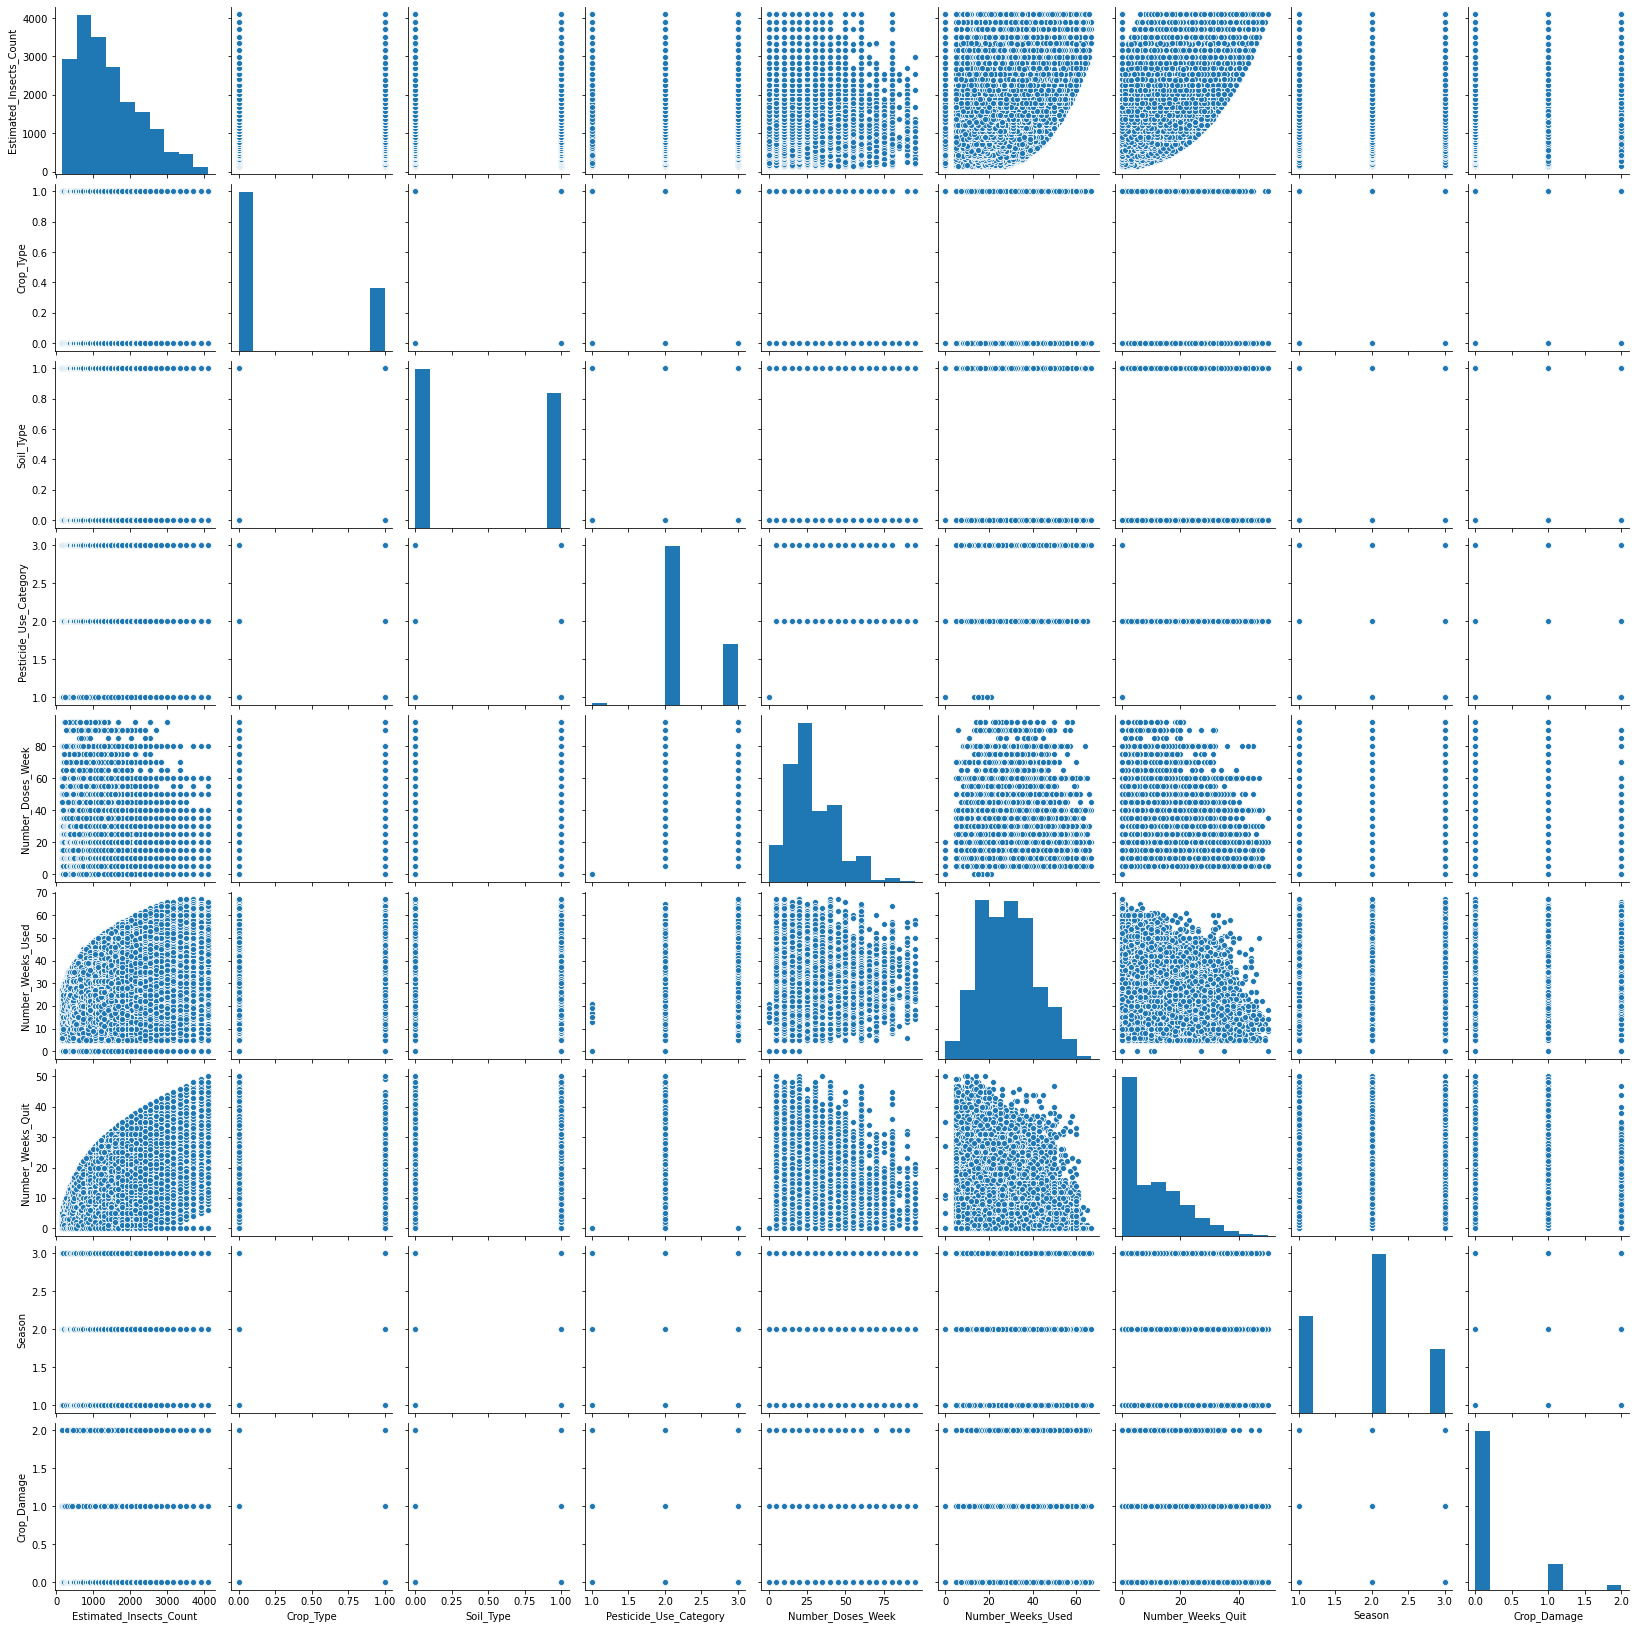

In [14]:
import seaborn as sns
sns.pairplot(df_train)


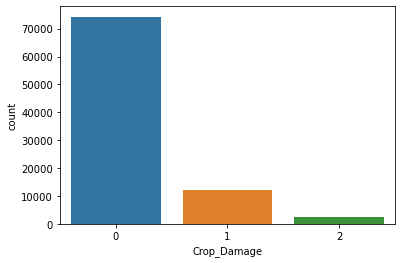

In [15]:
df_train['Crop_Damage'].value_counts()
sns.countplot(df_train['Crop_Damage'])


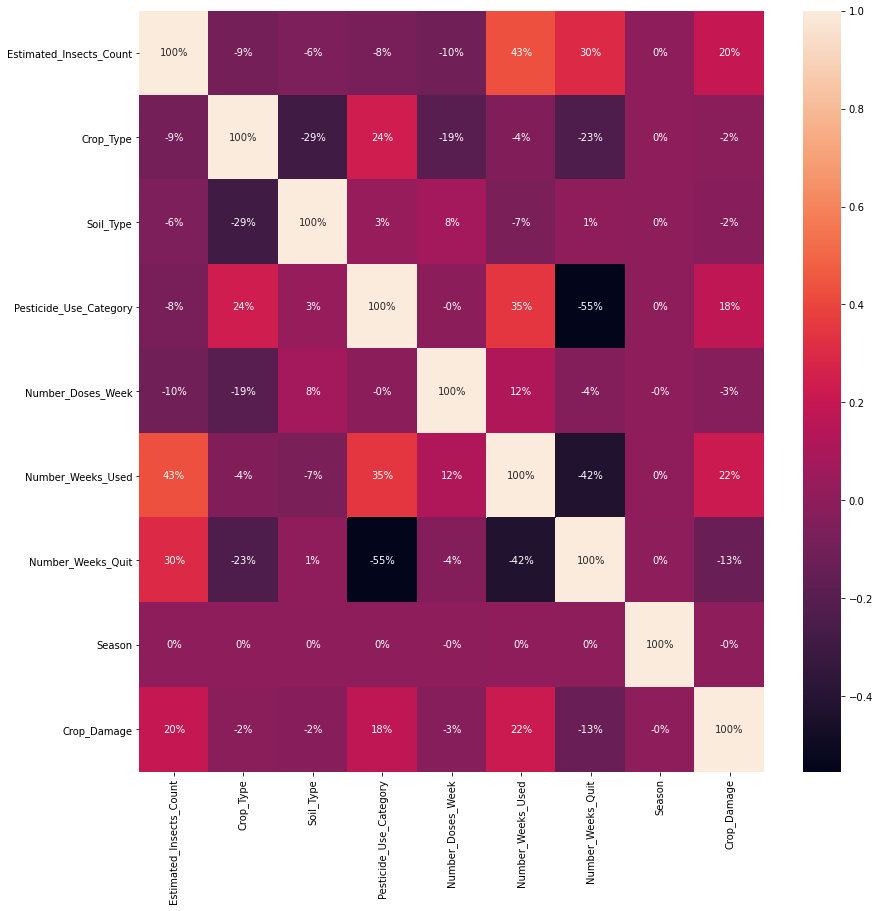

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))  #14in by 14in
sns.heatmap(df_train.corr(), annot=True, fmt='.0%')

In [17]:
X = df_train.iloc[: ,1:-1].values
y = df_train.iloc[: , -1].values


In [18]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X)
#mm_scaler.transform(X)

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=10,
                             n_estimators=190,
                             criterion='gini',
                            max_depth=1,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             bootstrap=True,
                            n_jobs=-1,verbose=False)

clf.fit(X_train_minmax, y)

RandomForestClassifier(max_depth=1, n_estimators=190, n_jobs=-1,
                       random_state=10, verbose=False)

In [20]:
clf.score(X_train_minmax,y)

0.8354678250692116

In [21]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train_minmax, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
classifier_xgb.score(X_train_minmax,y)

0.8558036417655135

In [23]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [24]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [25]:
df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [26]:
df_data = df_data.sort_values(['ID_value'])

In [27]:
df_data = df_data.reset_index(drop=True)

In [28]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [29]:
df_data.head(3)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,...,Soil_Type_Damage,Estimated_Insects_Count_Damage,Crop_Type_Damage,Pesticide_Use_Category_Damage,Season_Damage,Soil_Type_Damage_lag2,Estimated_Insects_Count_Damage_lag2,Crop_Type_Damage_lag2,Pesticide_Use_Category_Damage_lag2,Season_Damage_lag2
0,F00000001,188,1,0,1,0,0.0,0,1,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,F00000002,188,1,1,1,0,0.0,0,2,0,...,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,F00000003,209,1,0,1,0,0.0,0,2,1,...,0.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0


In [30]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [31]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)

In [32]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [33]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [35]:
del df_data

In [36]:
missing_impute = -999

In [37]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [38]:
df_train, df_eval = train_test_split(df_train, test_size=0.20, random_state=42, shuffle=True, stratify=df_train[label_col])

In [39]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [40]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [41]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [42]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_lag1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_lag1', 'Season', 'Season_lag1', 'Soil_Type', 'Soil_Type_lag1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.497225	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.497232
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.478827	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.478946
[3]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.4625	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.462723
[4]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.447848	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.44808
[5]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.434573	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.434844
[6]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.424255	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.424608
[7]	valid_0's multi_error: 0.164533	valid_0's multi_logloss: 0.413502	valid_1's multi_error: 0.164528	valid_1's multi_logloss

[63]	valid_0's multi_error: 0.076105	valid_0's multi_logloss: 0.222716	valid_1's multi_error: 0.0756246	valid_1's multi_logloss: 0.226832
[64]	valid_0's multi_error: 0.0757392	valid_0's multi_logloss: 0.22175	valid_1's multi_error: 0.075512	valid_1's multi_logloss: 0.225881
[65]	valid_0's multi_error: 0.0751484	valid_0's multi_logloss: 0.220399	valid_1's multi_error: 0.0752307	valid_1's multi_logloss: 0.224616
[66]	valid_0's multi_error: 0.0747967	valid_0's multi_logloss: 0.219163	valid_1's multi_error: 0.0750056	valid_1's multi_logloss: 0.223459
[67]	valid_0's multi_error: 0.0744732	valid_0's multi_logloss: 0.218093	valid_1's multi_error: 0.0748368	valid_1's multi_logloss: 0.222468
[68]	valid_0's multi_error: 0.074023	valid_0's multi_logloss: 0.216696	valid_1's multi_error: 0.0746117	valid_1's multi_logloss: 0.221177
[69]	valid_0's multi_error: 0.073601	valid_0's multi_logloss: 0.215482	valid_1's multi_error: 0.0743304	valid_1's multi_logloss: 0.220071
[70]	valid_0's multi_error: 0.07

[122]	valid_0's multi_error: 0.0628394	valid_0's multi_logloss: 0.182128	valid_1's multi_error: 0.0648211	valid_1's multi_logloss: 0.190301
[123]	valid_0's multi_error: 0.062769	valid_0's multi_logloss: 0.181826	valid_1's multi_error: 0.0647085	valid_1's multi_logloss: 0.190082
[124]	valid_0's multi_error: 0.0626424	valid_0's multi_logloss: 0.181499	valid_1's multi_error: 0.0644272	valid_1's multi_logloss: 0.189837
[125]	valid_0's multi_error: 0.0626143	valid_0's multi_logloss: 0.181118	valid_1's multi_error: 0.0644835	valid_1's multi_logloss: 0.189536
[126]	valid_0's multi_error: 0.0623611	valid_0's multi_logloss: 0.180548	valid_1's multi_error: 0.0642021	valid_1's multi_logloss: 0.189033
[127]	valid_0's multi_error: 0.0621501	valid_0's multi_logloss: 0.180013	valid_1's multi_error: 0.0640896	valid_1's multi_logloss: 0.188554
[128]	valid_0's multi_error: 0.0618828	valid_0's multi_logloss: 0.179449	valid_1's multi_error: 0.0636957	valid_1's multi_logloss: 0.18804
[129]	valid_0's multi_

[183]	valid_0's multi_error: 0.0558056	valid_0's multi_logloss: 0.161207	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.173494
[184]	valid_0's multi_error: 0.0556931	valid_0's multi_logloss: 0.161026	valid_1's multi_error: 0.0588566	valid_1's multi_logloss: 0.173399
[185]	valid_0's multi_error: 0.0556228	valid_0's multi_logloss: 0.160854	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.173297
[186]	valid_0's multi_error: 0.055454	valid_0's multi_logloss: 0.160633	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.173154
[187]	valid_0's multi_error: 0.0553977	valid_0's multi_logloss: 0.160412	valid_1's multi_error: 0.0590817	valid_1's multi_logloss: 0.173
[188]	valid_0's multi_error: 0.0553555	valid_0's multi_logloss: 0.160217	valid_1's multi_error: 0.0590254	valid_1's multi_logloss: 0.172883
[189]	valid_0's multi_error: 0.0552148	valid_0's multi_logloss: 0.159812	valid_1's multi_error: 0.0590254	valid_1's multi_logloss: 0.172532
[190]	valid_0's multi_er

[243]	valid_0's multi_error: 0.0510368	valid_0's multi_logloss: 0.147742	valid_1's multi_error: 0.0560995	valid_1's multi_logloss: 0.164011
[244]	valid_0's multi_error: 0.0510508	valid_0's multi_logloss: 0.147566	valid_1's multi_error: 0.056212	valid_1's multi_logloss: 0.16387
[245]	valid_0's multi_error: 0.0510227	valid_0's multi_logloss: 0.147405	valid_1's multi_error: 0.0560995	valid_1's multi_logloss: 0.163799
[246]	valid_0's multi_error: 0.0510227	valid_0's multi_logloss: 0.147305	valid_1's multi_error: 0.0559869	valid_1's multi_logloss: 0.16377
[247]	valid_0's multi_error: 0.0509664	valid_0's multi_logloss: 0.147168	valid_1's multi_error: 0.0559307	valid_1's multi_logloss: 0.16369
[248]	valid_0's multi_error: 0.0509524	valid_0's multi_logloss: 0.147017	valid_1's multi_error: 0.0559869	valid_1's multi_logloss: 0.163605
[249]	valid_0's multi_error: 0.0509102	valid_0's multi_logloss: 0.146841	valid_1's multi_error: 0.0558181	valid_1's multi_logloss: 0.163496
[250]	valid_0's multi_er

[305]	valid_0's multi_error: 0.0482655	valid_0's multi_logloss: 0.138803	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.15935
[306]	valid_0's multi_error: 0.0482092	valid_0's multi_logloss: 0.138648	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.159251
[307]	valid_0's multi_error: 0.0481951	valid_0's multi_logloss: 0.138565	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.159252
[308]	valid_0's multi_error: 0.0481389	valid_0's multi_logloss: 0.138429	valid_1's multi_error: 0.054524	valid_1's multi_logloss: 0.159187
[309]	valid_0's multi_error: 0.0480967	valid_0's multi_logloss: 0.13828	valid_1's multi_error: 0.0544114	valid_1's multi_logloss: 0.159073
[310]	valid_0's multi_error: 0.0480263	valid_0's multi_logloss: 0.138164	valid_1's multi_error: 0.0543552	valid_1's multi_logloss: 0.15901
[311]	valid_0's multi_error: 0.0479982	valid_0's multi_logloss: 0.138045	valid_1's multi_error: 0.0544114	valid_1's multi_logloss: 0.15896
[312]	valid_0's multi_err

[365]	valid_0's multi_error: 0.0453676	valid_0's multi_logloss: 0.131306	valid_1's multi_error: 0.0531735	valid_1's multi_logloss: 0.155434
[366]	valid_0's multi_error: 0.0453535	valid_0's multi_logloss: 0.131216	valid_1's multi_error: 0.0531735	valid_1's multi_logloss: 0.15541
[367]	valid_0's multi_error: 0.0452972	valid_0's multi_logloss: 0.131127	valid_1's multi_error: 0.0532861	valid_1's multi_logloss: 0.155396
[368]	valid_0's multi_error: 0.0453254	valid_0's multi_logloss: 0.131024	valid_1's multi_error: 0.053061	valid_1's multi_logloss: 0.155358
[369]	valid_0's multi_error: 0.0452128	valid_0's multi_logloss: 0.130894	valid_1's multi_error: 0.053061	valid_1's multi_logloss: 0.15527
[370]	valid_0's multi_error: 0.0451566	valid_0's multi_logloss: 0.130734	valid_1's multi_error: 0.053061	valid_1's multi_logloss: 0.155161
[371]	valid_0's multi_error: 0.0451566	valid_0's multi_logloss: 0.130619	valid_1's multi_error: 0.0529485	valid_1's multi_logloss: 0.155108
[372]	valid_0's multi_err

[424]	valid_0's multi_error: 0.043159	valid_0's multi_logloss: 0.124905	valid_1's multi_error: 0.0526671	valid_1's multi_logloss: 0.152452
[425]	valid_0's multi_error: 0.0431168	valid_0's multi_logloss: 0.124761	valid_1's multi_error: 0.0525546	valid_1's multi_logloss: 0.152365
[426]	valid_0's multi_error: 0.0431168	valid_0's multi_logloss: 0.124619	valid_1's multi_error: 0.0524983	valid_1's multi_logloss: 0.152283
[427]	valid_0's multi_error: 0.0429902	valid_0's multi_logloss: 0.124513	valid_1's multi_error: 0.0523858	valid_1's multi_logloss: 0.15223
[428]	valid_0's multi_error: 0.0429339	valid_0's multi_logloss: 0.124447	valid_1's multi_error: 0.052442	valid_1's multi_logloss: 0.15222
[429]	valid_0's multi_error: 0.0428495	valid_0's multi_logloss: 0.124254	valid_1's multi_error: 0.0523858	valid_1's multi_logloss: 0.152062
[430]	valid_0's multi_error: 0.0427932	valid_0's multi_logloss: 0.124166	valid_1's multi_error: 0.0523858	valid_1's multi_logloss: 0.152041
[431]	valid_0's multi_er

[484]	valid_0's multi_error: 0.0410489	valid_0's multi_logloss: 0.118561	valid_1's multi_error: 0.0513729	valid_1's multi_logloss: 0.149274
[485]	valid_0's multi_error: 0.0410489	valid_0's multi_logloss: 0.118485	valid_1's multi_error: 0.0512604	valid_1's multi_logloss: 0.149248
[486]	valid_0's multi_error: 0.0410348	valid_0's multi_logloss: 0.118415	valid_1's multi_error: 0.0513167	valid_1's multi_logloss: 0.149223
[487]	valid_0's multi_error: 0.0409645	valid_0's multi_logloss: 0.118263	valid_1's multi_error: 0.0512604	valid_1's multi_logloss: 0.149106
[488]	valid_0's multi_error: 0.0409504	valid_0's multi_logloss: 0.118176	valid_1's multi_error: 0.0512604	valid_1's multi_logloss: 0.149074
[489]	valid_0's multi_error: 0.0408801	valid_0's multi_logloss: 0.118074	valid_1's multi_error: 0.0513167	valid_1's multi_logloss: 0.149007
[490]	valid_0's multi_error: 0.0408238	valid_0's multi_logloss: 0.117994	valid_1's multi_error: 0.0513729	valid_1's multi_logloss: 0.14896
[491]	valid_0's multi

[546]	valid_0's multi_error: 0.0392482	valid_0's multi_logloss: 0.113763	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.14766
[547]	valid_0's multi_error: 0.0392342	valid_0's multi_logloss: 0.113693	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.14765
[548]	valid_0's multi_error: 0.0392201	valid_0's multi_logloss: 0.113627	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.147638
[549]	valid_0's multi_error: 0.039206	valid_0's multi_logloss: 0.113564	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.147625
[550]	valid_0's multi_error: 0.039192	valid_0's multi_logloss: 0.113504	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.147625
[551]	valid_0's multi_error: 0.0391638	valid_0's multi_logloss: 0.113426	valid_1's multi_error: 0.0503601	valid_1's multi_logloss: 0.147593
[552]	valid_0's multi_error: 0.039192	valid_0's multi_logloss: 0.113358	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.147584
[553]	valid_0's multi_err

[608]	valid_0's multi_error: 0.0375742	valid_0's multi_logloss: 0.109442	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146466
[609]	valid_0's multi_error: 0.0375601	valid_0's multi_logloss: 0.109389	valid_1's multi_error: 0.0498537	valid_1's multi_logloss: 0.146461
[610]	valid_0's multi_error: 0.0375461	valid_0's multi_logloss: 0.109328	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.146469
[611]	valid_0's multi_error: 0.0375461	valid_0's multi_logloss: 0.109243	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.146432
[612]	valid_0's multi_error: 0.0375179	valid_0's multi_logloss: 0.109201	valid_1's multi_error: 0.04991	valid_1's multi_logloss: 0.14644
[613]	valid_0's multi_error: 0.0374898	valid_0's multi_logloss: 0.109139	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146426
[614]	valid_0's multi_error: 0.0375039	valid_0's multi_logloss: 0.109082	valid_1's multi_error: 0.0500225	valid_1's multi_logloss: 0.146407
[615]	valid_0's multi_error

[671]	valid_0's multi_error: 0.0359986	valid_0's multi_logloss: 0.10553	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145427
[672]	valid_0's multi_error: 0.0359564	valid_0's multi_logloss: 0.105453	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145384
[673]	valid_0's multi_error: 0.0359705	valid_0's multi_logloss: 0.105392	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145365
[674]	valid_0's multi_error: 0.0359846	valid_0's multi_logloss: 0.105338	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145369
[675]	valid_0's multi_error: 0.0359283	valid_0's multi_logloss: 0.105272	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.14536
[676]	valid_0's multi_error: 0.0359424	valid_0's multi_logloss: 0.105199	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145352
[677]	valid_0's multi_error: 0.0359002	valid_0's multi_logloss: 0.105154	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145345
[678]	valid_0's multi_

[731]	valid_0's multi_error: 0.0348029	valid_0's multi_logloss: 0.101955	valid_1's multi_error: 0.0492348	valid_1's multi_logloss: 0.144651
[732]	valid_0's multi_error: 0.0347888	valid_0's multi_logloss: 0.101884	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144623
[733]	valid_0's multi_error: 0.0347466	valid_0's multi_logloss: 0.101811	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.14459
[734]	valid_0's multi_error: 0.0347185	valid_0's multi_logloss: 0.101756	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144569
[735]	valid_0's multi_error: 0.0346763	valid_0's multi_logloss: 0.1017	valid_1's multi_error: 0.0491785	valid_1's multi_logloss: 0.144558
[736]	valid_0's multi_error: 0.0346482	valid_0's multi_logloss: 0.101645	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.144554
[737]	valid_0's multi_error: 0.0346482	valid_0's multi_logloss: 0.101581	valid_1's multi_error: 0.0491222	valid_1's multi_logloss: 0.144538
[738]	valid_0's multi_e

[792]	valid_0's multi_error: 0.0332977	valid_0's multi_logloss: 0.0984891	valid_1's multi_error: 0.0487283	valid_1's multi_logloss: 0.143883
[793]	valid_0's multi_error: 0.0332696	valid_0's multi_logloss: 0.0984435	valid_1's multi_error: 0.0487283	valid_1's multi_logloss: 0.143888
[794]	valid_0's multi_error: 0.0332133	valid_0's multi_logloss: 0.0983811	valid_1's multi_error: 0.0487283	valid_1's multi_logloss: 0.143875
[795]	valid_0's multi_error: 0.033157	valid_0's multi_logloss: 0.098332	valid_1's multi_error: 0.0487846	valid_1's multi_logloss: 0.14387
[796]	valid_0's multi_error: 0.033157	valid_0's multi_logloss: 0.0982839	valid_1's multi_error: 0.0487846	valid_1's multi_logloss: 0.14386
[797]	valid_0's multi_error: 0.033157	valid_0's multi_logloss: 0.0982369	valid_1's multi_error: 0.0487283	valid_1's multi_logloss: 0.143848
[798]	valid_0's multi_error: 0.0330726	valid_0's multi_logloss: 0.0981949	valid_1's multi_error: 0.0487283	valid_1's multi_logloss: 0.143845
[799]	valid_0's mul

[854]	valid_0's multi_error: 0.0319894	valid_0's multi_logloss: 0.0953168	valid_1's multi_error: 0.0482782	valid_1's multi_logloss: 0.143165
[855]	valid_0's multi_error: 0.031905	valid_0's multi_logloss: 0.0952595	valid_1's multi_error: 0.0481657	valid_1's multi_logloss: 0.143142
[856]	valid_0's multi_error: 0.0319191	valid_0's multi_logloss: 0.095217	valid_1's multi_error: 0.0482782	valid_1's multi_logloss: 0.143154
[857]	valid_0's multi_error: 0.0319191	valid_0's multi_logloss: 0.0951759	valid_1's multi_error: 0.0482782	valid_1's multi_logloss: 0.143139
[858]	valid_0's multi_error: 0.031905	valid_0's multi_logloss: 0.0951291	valid_1's multi_error: 0.0482219	valid_1's multi_logloss: 0.143136
[859]	valid_0's multi_error: 0.031905	valid_0's multi_logloss: 0.0950893	valid_1's multi_error: 0.0482219	valid_1's multi_logloss: 0.143143
[860]	valid_0's multi_error: 0.031905	valid_0's multi_logloss: 0.0950494	valid_1's multi_error: 0.0482219	valid_1's multi_logloss: 0.143132
[861]	valid_0's mu

[913]	valid_0's multi_error: 0.0307656	valid_0's multi_logloss: 0.0923352	valid_1's multi_error: 0.0479406	valid_1's multi_logloss: 0.142503
[914]	valid_0's multi_error: 0.0307233	valid_0's multi_logloss: 0.0922877	valid_1's multi_error: 0.0479968	valid_1's multi_logloss: 0.142514
[915]	valid_0's multi_error: 0.0307233	valid_0's multi_logloss: 0.092251	valid_1's multi_error: 0.0479968	valid_1's multi_logloss: 0.142509
[916]	valid_0's multi_error: 0.0306952	valid_0's multi_logloss: 0.092203	valid_1's multi_error: 0.0479406	valid_1's multi_logloss: 0.1425
[917]	valid_0's multi_error: 0.0306952	valid_0's multi_logloss: 0.0921605	valid_1's multi_error: 0.0479968	valid_1's multi_logloss: 0.142504
[918]	valid_0's multi_error: 0.0306811	valid_0's multi_logloss: 0.0921179	valid_1's multi_error: 0.0479968	valid_1's multi_logloss: 0.142506
[919]	valid_0's multi_error: 0.030653	valid_0's multi_logloss: 0.0920654	valid_1's multi_error: 0.0479968	valid_1's multi_logloss: 0.142491
[920]	valid_0's mu

[977]	valid_0's multi_error: 0.0294573	valid_0's multi_logloss: 0.0893696	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.142179
[978]	valid_0's multi_error: 0.0294854	valid_0's multi_logloss: 0.0893241	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.142176
[979]	valid_0's multi_error: 0.0294713	valid_0's multi_logloss: 0.0892888	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.142175
[980]	valid_0's multi_error: 0.029401	valid_0's multi_logloss: 0.0892339	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.142159
[981]	valid_0's multi_error: 0.029401	valid_0's multi_logloss: 0.0891952	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.142168
[982]	valid_0's multi_error: 0.0293588	valid_0's multi_logloss: 0.0891575	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.142166
[983]	valid_0's multi_error: 0.0293588	valid_0's multi_logloss: 0.0891023	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.142145
[984]	valid_0's

[1037]	valid_0's multi_error: 0.0281771	valid_0's multi_logloss: 0.0866973	valid_1's multi_error: 0.0472654	valid_1's multi_logloss: 0.141575
[1038]	valid_0's multi_error: 0.028149	valid_0's multi_logloss: 0.086657	valid_1's multi_error: 0.0473216	valid_1's multi_logloss: 0.141571
[1039]	valid_0's multi_error: 0.028149	valid_0's multi_logloss: 0.0866073	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.141555
[1040]	valid_0's multi_error: 0.0281771	valid_0's multi_logloss: 0.0865657	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.141554
[1041]	valid_0's multi_error: 0.0281771	valid_0's multi_logloss: 0.0865217	valid_1's multi_error: 0.0474342	valid_1's multi_logloss: 0.141548
[1042]	valid_0's multi_error: 0.0281912	valid_0's multi_logloss: 0.0864782	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.141539
[1043]	valid_0's multi_error: 0.0281349	valid_0's multi_logloss: 0.0864088	valid_1's multi_error: 0.0473779	valid_1's multi_logloss: 0.141491
[1044]	va

[1098]	valid_0's multi_error: 0.0272346	valid_0's multi_logloss: 0.0840581	valid_1's multi_error: 0.0471528	valid_1's multi_logloss: 0.141111
[1099]	valid_0's multi_error: 0.0271783	valid_0's multi_logloss: 0.0840197	valid_1's multi_error: 0.0471528	valid_1's multi_logloss: 0.141103
[1100]	valid_0's multi_error: 0.0271502	valid_0's multi_logloss: 0.083986	valid_1's multi_error: 0.0471528	valid_1's multi_logloss: 0.141104
[1101]	valid_0's multi_error: 0.0271221	valid_0's multi_logloss: 0.0839458	valid_1's multi_error: 0.0472091	valid_1's multi_logloss: 0.141103
[1102]	valid_0's multi_error: 0.0270939	valid_0's multi_logloss: 0.0839043	valid_1's multi_error: 0.0472091	valid_1's multi_logloss: 0.141101
[1103]	valid_0's multi_error: 0.0270236	valid_0's multi_logloss: 0.0838677	valid_1's multi_error: 0.0472091	valid_1's multi_logloss: 0.141112
[1104]	valid_0's multi_error: 0.0270236	valid_0's multi_logloss: 0.0838331	valid_1's multi_error: 0.0472091	valid_1's multi_logloss: 0.14112
[1105]	v

[1161]	valid_0's multi_error: 0.0260389	valid_0's multi_logloss: 0.0815661	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140876
[1162]	valid_0's multi_error: 0.0260107	valid_0's multi_logloss: 0.0815319	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140866
[1163]	valid_0's multi_error: 0.0259545	valid_0's multi_logloss: 0.0814829	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140862
[1164]	valid_0's multi_error: 0.0259263	valid_0's multi_logloss: 0.0814458	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140851
[1165]	valid_0's multi_error: 0.0259263	valid_0's multi_logloss: 0.0814056	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140834
[1166]	valid_0's multi_error: 0.0258701	valid_0's multi_logloss: 0.0813625	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.14082
[1167]	valid_0's multi_error: 0.0258701	valid_0's multi_logloss: 0.0813293	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140824
[1168]	

[1221]	valid_0's multi_error: 0.0249416	valid_0's multi_logloss: 0.0793295	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140629
[1222]	valid_0's multi_error: 0.0249416	valid_0's multi_logloss: 0.0792941	valid_1's multi_error: 0.0470966	valid_1's multi_logloss: 0.140629
[1223]	valid_0's multi_error: 0.0248854	valid_0's multi_logloss: 0.079254	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140631
[1224]	valid_0's multi_error: 0.0248713	valid_0's multi_logloss: 0.0792178	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140637
[1225]	valid_0's multi_error: 0.0248431	valid_0's multi_logloss: 0.0791794	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140631
[1226]	valid_0's multi_error: 0.0248291	valid_0's multi_logloss: 0.0791479	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140623
[1227]	valid_0's multi_error: 0.0248431	valid_0's multi_logloss: 0.0791076	valid_1's multi_error: 0.046984	valid_1's multi_logloss: 0.140622
[1228]	valid_

[1279]	valid_0's multi_error: 0.0240272	valid_0's multi_logloss: 0.0772019	valid_1's multi_error: 0.0468152	valid_1's multi_logloss: 0.140278
[1280]	valid_0's multi_error: 0.0240132	valid_0's multi_logloss: 0.077159	valid_1's multi_error: 0.0467589	valid_1's multi_logloss: 0.140274
[1281]	valid_0's multi_error: 0.023985	valid_0's multi_logloss: 0.0771192	valid_1's multi_error: 0.0467589	valid_1's multi_logloss: 0.140266
[1282]	valid_0's multi_error: 0.023985	valid_0's multi_logloss: 0.0770942	valid_1's multi_error: 0.0467589	valid_1's multi_logloss: 0.140266
[1283]	valid_0's multi_error: 0.0239569	valid_0's multi_logloss: 0.0770588	valid_1's multi_error: 0.0467589	valid_1's multi_logloss: 0.14026
[1284]	valid_0's multi_error: 0.0239569	valid_0's multi_logloss: 0.0770201	valid_1's multi_error: 0.0467027	valid_1's multi_logloss: 0.140259
[1285]	valid_0's multi_error: 0.0239428	valid_0's multi_logloss: 0.0769997	valid_1's multi_error: 0.0467027	valid_1's multi_logloss: 0.140272
[1286]	val

[1337]	valid_0's multi_error: 0.0230988	valid_0's multi_logloss: 0.075237	valid_1's multi_error: 0.0464776	valid_1's multi_logloss: 0.140054
[1338]	valid_0's multi_error: 0.0230706	valid_0's multi_logloss: 0.0751915	valid_1's multi_error: 0.0464776	valid_1's multi_logloss: 0.140046
[1339]	valid_0's multi_error: 0.0230425	valid_0's multi_logloss: 0.0751601	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.140048
[1340]	valid_0's multi_error: 0.0230566	valid_0's multi_logloss: 0.0751229	valid_1's multi_error: 0.0465901	valid_1's multi_logloss: 0.140045
[1341]	valid_0's multi_error: 0.0230003	valid_0's multi_logloss: 0.0750854	valid_1's multi_error: 0.0466464	valid_1's multi_logloss: 0.140049
[1342]	valid_0's multi_error: 0.0230003	valid_0's multi_logloss: 0.0750555	valid_1's multi_error: 0.0466464	valid_1's multi_logloss: 0.140054
[1343]	valid_0's multi_error: 0.0229722	valid_0's multi_logloss: 0.0750057	valid_1's multi_error: 0.0467027	valid_1's multi_logloss: 0.140049
[1344]	

[1396]	valid_0's multi_error: 0.0221563	valid_0's multi_logloss: 0.0732204	valid_1's multi_error: 0.0467027	valid_1's multi_logloss: 0.139861
[1397]	valid_0's multi_error: 0.0220859	valid_0's multi_logloss: 0.0731784	valid_1's multi_error: 0.0466464	valid_1's multi_logloss: 0.139828
[1398]	valid_0's multi_error: 0.0220578	valid_0's multi_logloss: 0.0731457	valid_1's multi_error: 0.0466464	valid_1's multi_logloss: 0.139829
[1399]	valid_0's multi_error: 0.0220156	valid_0's multi_logloss: 0.0730974	valid_1's multi_error: 0.0465901	valid_1's multi_logloss: 0.139796
[1400]	valid_0's multi_error: 0.0219875	valid_0's multi_logloss: 0.0730529	valid_1's multi_error: 0.0465901	valid_1's multi_logloss: 0.13978
[1401]	valid_0's multi_error: 0.0219734	valid_0's multi_logloss: 0.0730164	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139767
[1402]	valid_0's multi_error: 0.021903	valid_0's multi_logloss: 0.0729781	valid_1's multi_error: 0.0464776	valid_1's multi_logloss: 0.13975
[1403]	va

[1456]	valid_0's multi_error: 0.0212559	valid_0's multi_logloss: 0.0712762	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139529
[1457]	valid_0's multi_error: 0.0212278	valid_0's multi_logloss: 0.0712486	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139528
[1458]	valid_0's multi_error: 0.0212419	valid_0's multi_logloss: 0.0712166	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139525
[1459]	valid_0's multi_error: 0.0212278	valid_0's multi_logloss: 0.0711772	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139497
[1460]	valid_0's multi_error: 0.0212137	valid_0's multi_logloss: 0.0711458	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139498
[1461]	valid_0's multi_error: 0.0212137	valid_0's multi_logloss: 0.0711148	valid_1's multi_error: 0.0465339	valid_1's multi_logloss: 0.139483
[1462]	valid_0's multi_error: 0.0212559	valid_0's multi_logloss: 0.0710643	valid_1's multi_error: 0.0465901	valid_1's multi_logloss: 0.139455
[1463]

In [43]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1407, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [44]:
clf.score(df_eval[feature_cols], df_eval[label_col])

0.9535786630654963

In [45]:
clf.score(df_train[feature_cols], df_train[label_col])

0.9781250879216723

**Github profile link**
https://github.com/umeshyadav99